In [3]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [63]:
class_names = ["VEHICLE", "PEDESTRIAN", "CYCLIST"]

# Load data
folder = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/output/avltruck_models/pvrcnnpp_STzod/D6_10epochs_STzod_ft_D16_50epochs_ros/eval/"


# get all subfolders, each subfoler is a different epoch
epoch_folders = [f.path for f in os.scandir(folder) if f.is_dir() ]

#remove folder that contains "eval_with_train"
epoch_folders = [folder for folder in epoch_folders if "eval_with_train" not in folder]

results_df = pd.DataFrame()
for folder in epoch_folders:
    epoch_nr = folder.split("_")[-1]
    split_folder = [f.path for f in os.scandir(folder) if f.is_dir() ][0]
    eval_dataset_folder = [f.path for f in os.scandir(split_folder) if f.is_dir() ][0]
    #get all files that start with "log"
    files = [f.path for f in os.scandir(eval_dataset_folder) if f.name.startswith("log") ]
    files.sort()

    #load the last file as its the most recent one (regular text file)
    file = files[-1]

    with open(file) as f:
        lines = f.readlines()

    #get liens that start with any string in classes
    lines = [line for line in lines if line.startswith(tuple(class_names))]
    #check if there are any lines, if not, skip this file
    if len(lines) == 0:
        print("No lines starting with classes found, skipping file")

    #strip the lines
    lines = [line.strip() for line in lines]
    #remove the "\n"
    lines = [line.replace("\n", "") for line in lines]
    #split by ":" and keep second part
    values = [line.split(":")[1] for line in lines]
    #cast to float
    values = [float(line) for line in values]

    #split by "_" and keep first part
    classes = [line.split("_")[0] for line in lines]

    difficulties = [line.split("_")[1] for line in lines]
    #split by "/" and keep first part
    difficulties = [line.split("/")[0] for line in difficulties]

    metrics = [line.split("/")[1] for line in lines]
    metrics = [line.split(":")[0] for line in metrics]

    #convert to dataframe
    df = pd.DataFrame({"class": classes, "difficulty": difficulties, "metric": metrics, "value": values})
    #add epoch number
    df["epoch"] = int(epoch_nr)

    #concat to results_df
    results_df = pd.concat([results_df, df])

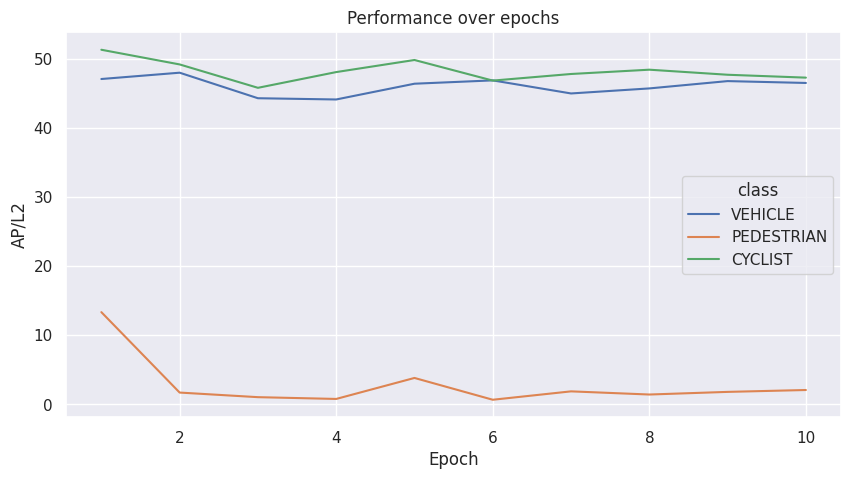

In [64]:
difficulty = "2"
metric = "AP"
#print difficutly 2 performance for each class over the epochs
results_df = results_df[results_df["difficulty"] == "2"]
results_df = results_df[results_df["metric"] == "AP"]

#sns print values over epochs with hue class
plt.figure(figsize=(10, 5))
sns.set_theme(style="darkgrid")

sns.lineplot(data=results_df, x="epoch", y="value", hue="class")
plt.title("Performance over epochs")
plt.ylabel(metric+"/L"+difficulty,)
plt.xlabel("Epoch")
plt.show()
